In [19]:
import pygame
import numpy as np
import random
from numba import njit #faster hard coding
import itertools #permutations

BOARD_SIZE = 8
CELL_SIZE = 60
MARGIN = 5
PIECE_AREA_HEIGHT = 200
PIECE_GAP = 20
SCREEN_WIDTH = BOARD_SIZE * (CELL_SIZE + MARGIN) + MARGIN
SCREEN_HEIGHT = SCREEN_WIDTH + PIECE_AREA_HEIGHT

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GRAY = (180, 180, 180)
BLUE = (50, 100, 255)
RED = (255, 50, 50)
GREEN = (0, 255, 0)

# Initialize Pygame
pygame.init()
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
pygame.display.set_caption("Block Blast (Prototype)")
clock = pygame.time.Clock()
font = pygame.font.SysFont(None, 36)

# Board
board = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)

BASE_PIECES = [
    np.array([[1, 1], [1, 1], [1, 1]]),                     # 0
    np.array([[1, 1, 1], [1, 0, 0], [1, 0, 0]]),             # 1
    np.array([[1], [1], [1], [1], [1]]),                    # 2
    np.array([[1], [1]]),                                   # 3
    np.array([[1], [1], [1], [1]]),                         # 4
    np.array([[1, 0], [1, 1], [1, 0]]),                      # 5
    np.ones((3, 3), dtype=int),                             # 6
    np.ones((2, 2), dtype=int),                             # 7
    np.array([[1, 1, 1]]),                                  # 8
    np.array([[1, 0], [1, 0], [1, 1]])                       # 9
]

BASE_WEIGHTS = [
    1.5,   # 0
    1.2,   # 1
    1,   # 2
    0.5,   # 3
    1.8,   # 4
    0.5,   # 5
    0.9,   # 6
    1.0,   # 7
    2.5,   # 8
    2.0    # 9
]

PIECES = []
PIECE_WEIGHTS = []

def weighted_piece_sample(n=3):
    samples = []
    # Step 1: choose which base-piece indices to draw
    base_indices = random.choices(
        population=range(len(BASE_PIECES)),
        weights=BASE_WEIGHTS,
        k=n
    )
    for idx in base_indices:
        base = BASE_PIECES[idx]
        # Step 2: build list of its unique rotations
        unique_rots = []
        for k in range(4):
            r = np.rot90(base, k=k)
            if not any(np.array_equal(r, u) for u in unique_rots):
                unique_rots.append(r)
        # Step 3: pick one rotation at random
        samples.append(random.choice(unique_rots))
    return samples
# Game state
pieces_in_play = weighted_piece_sample(3)
piece_rects = []
selected_piece = None
selected_offset = (0, 0)
selected_drag_pos = None
score = 0
combo_streak = 0
combo_counter = 0
cleared_in_this_set = False


class NeuralNetwork:
    def parameters(self):
        return [self.W1, self.b1, self.W2, self.b2,
                self.W3, self.b3, self.W4, self.b4]

    def load_parameters_from(self, other):
        for p_self, p_other in zip(self.parameters(), other.parameters()):
            np.copyto(p_self, p_other)
            
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
        self.W1 = np.random.randn(input_size, hidden1_size) * 0.01
        self.b1 = np.zeros((1, hidden1_size))

        self.W2 = np.random.randn(hidden1_size, hidden2_size) * 0.01
        self.b2 = np.zeros((1, hidden2_size))

        self.W3 = np.random.randn(hidden2_size, hidden3_size) * 0.01
        self.b3 = np.zeros((1, hidden3_size))

        self.W4 = np.random.randn(hidden3_size, output_size) * 0.01
        self.b4 = np.zeros((1, output_size))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)

        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.relu(self.Z3)

        self.Z4 = np.dot(self.A3, self.W4) + self.b4
        self.A4 = self.Z4  # Linear output
        return self.A4

    def backward(self, X, y_true, y_pred, lr):
        m = y_true.shape[0]

        # --- compute gradients and sanitize ---
        dZ4 = (y_pred - y_true) / m
        dZ4 = np.nan_to_num(dZ4, nan=0.0, posinf=1e6, neginf=-1e6)

        dW4 = np.dot(self.A3.T, dZ4)
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        dA3 = np.dot(dZ4, self.W4.T)
        dA3 = np.nan_to_num(dA3, nan=0.0, posinf=1e6, neginf=-1e6)

        dZ3 = dA3 * self.relu_derivative(self.Z3)
        dZ3 = np.nan_to_num(dZ3, nan=0.0, posinf=1e6, neginf=-1e6)
        dW3 = np.dot(self.A2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = np.dot(dZ3, self.W3.T)
        dA2 = np.nan_to_num(dA2, nan=0.0, posinf=1e6, neginf=-1e6)

        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dZ2 = np.nan_to_num(dZ2, nan=0.0, posinf=1e6, neginf=-1e6)
        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = np.dot(dZ2, self.W2.T)
        dA1 = np.nan_to_num(dA1, nan=0.0, posinf=1e6, neginf=-1e6)

        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dZ1 = np.nan_to_num(dZ1, nan=0.0, posinf=1e6, neginf=-1e6)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # --- gradient clipping to prevent explosions ---
        for grad in (dW1, dW2, dW3, dW4, db1, db2, db3, db4):
            np.clip(grad, -1.0, 1.0, out=grad)

        # --- parameter update ---
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W3 -= lr * dW3
        self.b3 -= lr * db3
        self.W4 -= lr * dW4
        self.b4 -= lr * db4

    def choose_action(self, board, pieces, actions, epsilon):
    # explore
        if random.random() < epsilon:
            return random.randrange(len(actions))
    
        # exploit: compute Q for each (piece,row,col)
        q_values = []
        for p_index, row, col in actions:
            piece = pieces[p_index]
            sa = encode_state_action(board, piece, row, col)
            q_values.append(self.forward(sa)[0,0])
    
        # pick the best
        return int(np.argmax(q_values))

def hand_is_valid(orig_board, pieces):
    """
    Return True if there exists an ordering of `pieces` and legal
    placements for all three (with clears).
    """
    memo = {}
    # helper to make a hashable key
    def make_key(board, rem_pieces):
        # board.tobytes() is fast and unique to cell contents
        board_key = board.tobytes()
        # each piece into bytes, then tuple
        pieces_key = tuple(p.tobytes() for p in rem_pieces)
        return (board_key, pieces_key)

    def dfs(board_state, remaining):
        key = make_key(board_state, remaining)
        if key in memo:
            return memo[key]

        if not remaining:
            memo[key] = True
            return True

        p = remaining[0]
        h, w = p.shape
        for r in range(BOARD_SIZE - h + 1):
            for c in range(BOARD_SIZE - w + 1):
                if can_place_py(board_state, p, r, c):
                    # simulate place + clear
                    nb = board_state.copy()
                    nb = place_piece(nb, p, r, c)
                    nb, _ = clear_lines(nb)

                    if dfs(nb, remaining[1:]):
                        memo[key] = True
                        return True

        memo[key] = False
        return False

    # try each ordering
    for perm in itertools.permutations(pieces):
        if dfs(orig_board.copy(), perm):
            return True

    return False

def draw_board():
    screen.fill(GRAY)
    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            x = MARGIN + j * (CELL_SIZE + MARGIN)
            y = MARGIN + i * (CELL_SIZE + MARGIN)
            color = BLACK if board[i, j] else WHITE
            pygame.draw.rect(screen, color, (x, y, CELL_SIZE, CELL_SIZE))


def draw_pieces():
    global piece_rects
    piece_rects = []
    start_y = SCREEN_WIDTH + MARGIN
    total_width = sum(p.shape[1] for p in pieces_in_play) * (CELL_SIZE + MARGIN) + (len(pieces_in_play) - 1) * 20
    current_x = (SCREEN_WIDTH - total_width) // 2

    for index, piece in enumerate(pieces_in_play):
        h, w = piece.shape
        offset_x = current_x
        offset_y = start_y
        rects = []
        for i in range(h):
            for j in range(w):
                if piece[i, j]:
                    x = offset_x + j * (CELL_SIZE + MARGIN)
                    y = offset_y + i * (CELL_SIZE + MARGIN)
                    rect = pygame.Rect(x, y, CELL_SIZE, CELL_SIZE)
                    pygame.draw.rect(screen, BLUE, rect)
                    rects.append(((i, j), rect))
        piece_rects.append((piece, rects, (offset_x, offset_y)))
        current_x += w * (CELL_SIZE + MARGIN) + 20

@njit
def can_place(board, piece, row, col):
    h, w = piece.shape
    if row < 0 or col < 0 or row + h > BOARD_SIZE or col + w > BOARD_SIZE:
        return False
    sub_board = board[row:row + h, col:col + w]
    return np.all((sub_board + piece) <= 1)

@njit
def place_piece(board, piece, row, col):
    h, w = piece.shape
    board[row:row + h, col:col + w] += piece
    return board

@njit
def clear_lines(board):
    cleared = 0
    for i in range(BOARD_SIZE):
        if np.all(board[i, :] == 1):
            board[i, :] = 0
            cleared += 1
    for j in range(BOARD_SIZE):
        if np.all(board[:, j] == 1):
            board[:, j] = 0
            cleared += 1
    return board, cleared
    
def can_place_py(board, piece, row, col):
    """
    Pure-Python placement test that exactly mirrors the NumPy/Numba
    version used elsewhere in the code base.
    """
    h, w = piece.shape

    # stay inside the 8×8 area
    if row < 0 or col < 0 or row + h > BOARD_SIZE or col + w > BOARD_SIZE:
        return False

    # vectorised overlap test – fast and consistent with can_place()
    sub_board = board[row:row + h, col:col + w]
    return np.all((sub_board + piece) <= 1)

def any_moves_left(board, pieces):
    """
    Return True if *any* of the given pieces can be placed somewhere on the board.
    """
    for piece in pieces:
        h, w = piece.shape
        for r in range(BOARD_SIZE - h + 1):
            for c in range(BOARD_SIZE - w + 1):
                if can_place_py(board, piece, r, c):
                    return True
    return False


def draw_score():
    score_text = font.render(f"Score: {score}", True, (0, 0, 0))
    combo_text = font.render(f"Combo: x{combo_streak if combo_streak > 0 else 1}", True, (0, 0, 0))
    screen.blit(score_text, (10, SCREEN_HEIGHT - 60))
    screen.blit(combo_text, (10, SCREEN_HEIGHT - 30))
    
_dummy_board = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
_dummy_piece = BASE_PIECES[0]

# “warm” the Numba jits so they compile before play
_ = can_place(_dummy_board, _dummy_piece, 0, 0)
_ = place_piece(_dummy_board.copy(), _dummy_piece, 0, 0)
_ = clear_lines(_dummy_board.copy())
# Main game loop
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            mx, my = pygame.mouse.get_pos()
            for index, (piece, rects, origin) in enumerate(piece_rects):
                for (i, j), rect in rects:
                    if rect.collidepoint(mx, my):
                        h, w = piece.shape
                        center_offset_x = (w * (CELL_SIZE + MARGIN)) // 2
                        center_offset_y = (h * (CELL_SIZE + MARGIN)) // 2
                        selected_piece = (index, piece, (center_offset_x, center_offset_y))
                        selected_drag_pos = (mx, my)
        elif event.type == pygame.MOUSEBUTTONUP and selected_piece:
            # unpack the dragged piece
            index, piece, offset = selected_piece
            mx, my = pygame.mouse.get_pos()
            x = mx - offset[0]
            y = my - offset[1]
            col = (x - MARGIN) // (CELL_SIZE + MARGIN)
            row = (y - MARGIN) // (CELL_SIZE + MARGIN)
        
            # only place if it fits
            if can_place(board, piece, row, col):
                # 1) Place & clear
                board = place_piece(board, piece, row, col)
                board, cleared = clear_lines(board)
                if cleared > 0:
                    combo_streak += cleared
                    score += cleared * 10 * combo_streak
                    cleared_in_this_set = True
        
                # 2) Remove that piece
                del pieces_in_play[index]
        
                # 3) If hand is empty, refill with at least one playable piece
                if not pieces_in_play:
                    if not cleared_in_this_set:
                        combo_streak = 0
                    cleared_in_this_set = False
        
                    # 3a) Check if board is truly dead (no base‐piece can fit)
                    board_dead = True
                    for base in BASE_PIECES:
                        h0, w0 = base.shape
                        for r0 in range(BOARD_SIZE - h0 + 1):
                            for c0 in range(BOARD_SIZE - w0 + 1):
                                if can_place_py(board, base, r0, c0):
                                    board_dead = False
                                    break
                            if not board_dead:
                                break
                        if not board_dead:
                            break
        
                    if board_dead:
                        print("Game Over!")
                        running = False
                    else:
                        while True:
                            new_hand = weighted_piece_sample(3)
                            if hand_is_valid(board, new_hand):
                                pieces_in_play = new_hand
                                break
                            
            # 4) reset the drag state
            selected_piece = None
            selected_drag_pos = None


    draw_board()
    draw_pieces()
    draw_score()
    if not any_moves_left(board, pieces_in_play):
        print("Game Over!")
        running = False
        break

    if selected_piece and selected_drag_pos:
        _, piece, offset = selected_piece
        mx, my = pygame.mouse.get_pos()
        x = mx - offset[0]
        y = my - offset[1]
        col = (x - MARGIN) // (CELL_SIZE + MARGIN)
        row = (y - MARGIN) // (CELL_SIZE + MARGIN)
        h, w = piece.shape
        for i in range(h):
            for j in range(w):
                px = mx - offset[0] + j * (CELL_SIZE + MARGIN)
                py = my - offset[1] + i * (CELL_SIZE + MARGIN)
                if piece[i, j]:
                    pygame.draw.rect(screen, RED, (px, py, CELL_SIZE, CELL_SIZE))
        if can_place(board, piece, row, col):
            for i in range(h):
                for j in range(w):
                    if piece[i, j]:
                        outline_x = MARGIN + (col + j) * (CELL_SIZE + MARGIN)
                        outline_y = MARGIN + (row + i) * (CELL_SIZE + MARGIN)
                        pygame.draw.rect(screen, GREEN, (outline_x, outline_y, CELL_SIZE, CELL_SIZE), 3)
                        
    

    pygame.display.flip()
    clock.tick(30)
    
    def encode_state_action(board, piece, row, col):
        board_flat = board.flatten()                      # (64,)
        action_mask = np.zeros_like(board_flat)           # (64,)
        h, w = piece.shape
        for i in range(h):
            for j in range(w):
                if piece[i, j]:
                    idx = (row + i) * BOARD_SIZE + (col + j)
                    action_mask[idx] = 1
        sa = np.concatenate([board_flat, action_mask]).astype(np.float32)
        return sa.reshape(1, -1)           

    
pygame.quit()


✅ Ep    0: Reward =    9.3, Steps =   15, Lines =    2, AvgHoles =  0.33
📈 100-ep Moving Avg Reward:    9.3, ε = 0.999
✅ Ep  100: Reward =  -26.8, Steps =   12, Lines =    0, AvgHoles =  1.17
📈 100-ep Moving Avg Reward:   -6.2, ε = 0.904
✅ Ep  200: Reward =  -35.3, Steps =   15, Lines =    1, AvgHoles =  1.87
📈 100-ep Moving Avg Reward:   -3.6, ε = 0.818
✅ Ep  300: Reward =   20.5, Steps =   18, Lines =    4, AvgHoles =  0.72
📈 100-ep Moving Avg Reward:   -6.3, ε = 0.740
✅ Ep  400: Reward =  -27.4, Steps =   15, Lines =    1, AvgHoles =  1.27
📈 100-ep Moving Avg Reward:   -3.9, ε = 0.670
✅ Ep  500: Reward =  -27.5, Steps =   12, Lines =    0, AvgHoles =  0.42
📈 100-ep Moving Avg Reward:   -1.1, ε = 0.606
✅ Ep  600: Reward =   12.2, Steps =   14, Lines =    3, AvgHoles =  1.29
📈 100-ep Moving Avg Reward:   -2.5, ε = 0.548
✅ Ep  700: Reward =   82.3, Steps =   26, Lines =    8, AvgHoles =  0.42
📈 100-ep Moving Avg Reward:    3.2, ε = 0.496
✅ Ep  800: Reward =   -0.5, Steps =    9, Lines 

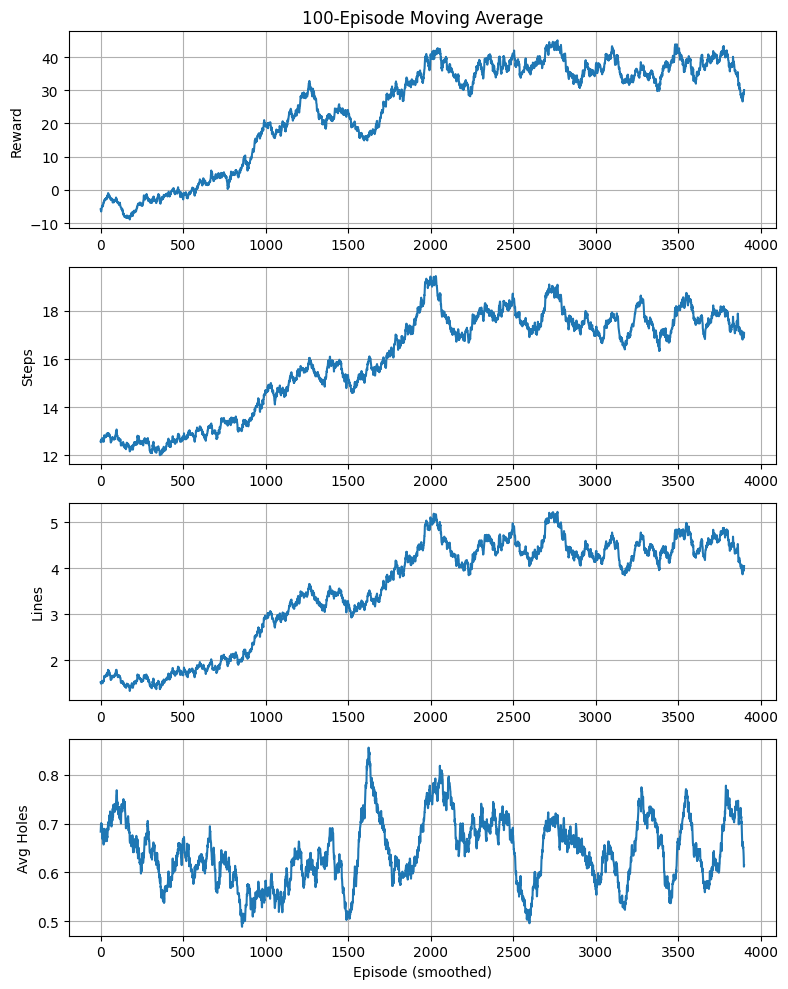

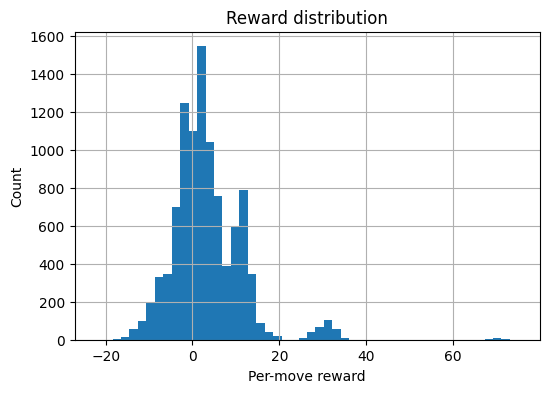

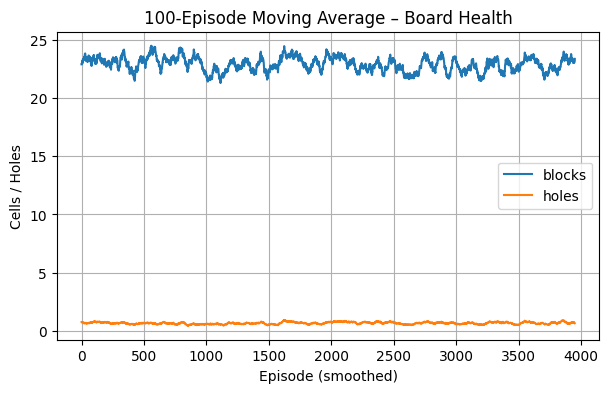

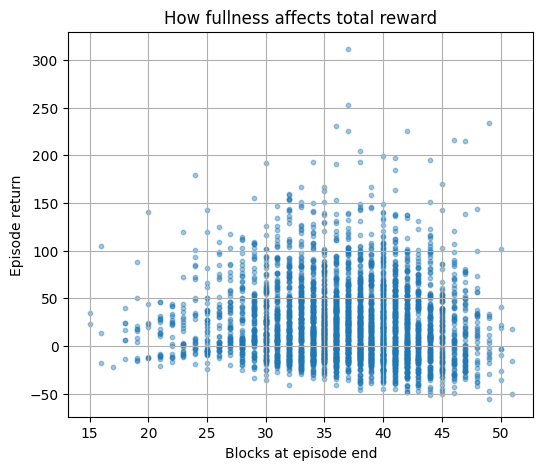

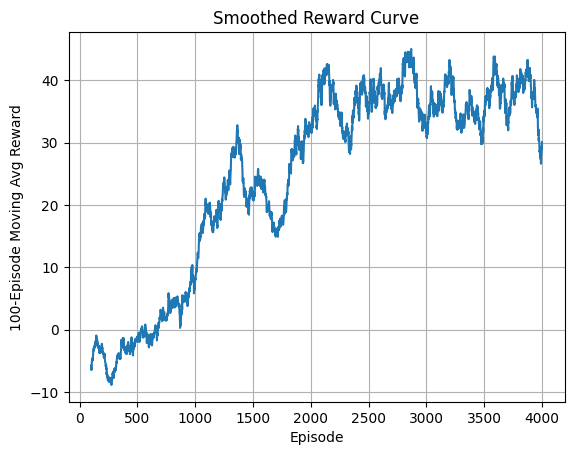

In [34]:
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------
               # shape (1,128)

# Keep your existing touching_blocks(...) and count_small_holes(...) here

# ------------------------------------------------------------------
# Instantiate network & buffers
# ------------------------------------------------------------------
online_nn  = NeuralNetwork(input_size=128, hidden1_size=128,
                           hidden2_size=128, hidden3_size=32, output_size=1)
target_nn  = copy.deepcopy(online_nn)

TARGET_UPDATE = 5000
grad_steps    = 0
block_weight = 0.1 
all_rewards = []
epsilon       = 1.0
epsilon_decay = 0.999
epsilon_min   = 0.07
lr            = 0.0007
gamma         = 0.98
episodes      = 4000
batch_size    = 64

memory         = deque(maxlen=10000)
recent_rewards = deque(maxlen=100)

def has_legal_action(board: np.ndarray, pieces) -> bool:
    """True iff *any* piece in the iterable can be placed on board."""
    for p in pieces:
        h, w = p.shape
        for r in range(BOARD_SIZE - h + 1):
            for c in range(BOARD_SIZE - w + 1):
                if can_place(board, p, r, c):
                    return True
    return False


def dead_after_move(board: np.ndarray, pieces) -> bool:
    """Convenience: no legal move left with current hand."""
    return not has_legal_action(board, pieces)

def update_set_counter(counter, just_cleared_hand):
    """
    Tracks how many pieces you've dropped since the last hand refill.
    Returns the *updated* counter; if hand was just refilled, resets to 0.
    """
    return 0 if just_cleared_hand else counter + 1

def count_small_holes(board):
    penalty = 0
    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            if board[i, j] == 0:
                # Check 1x1 isolated
                neighbors = [
                    board[i-1, j] if i > 0 else 1,
                    board[i+1, j] if i < BOARD_SIZE - 1 else 1,
                    board[i, j-1] if j > 0 else 1,
                    board[i, j+1] if j < BOARD_SIZE - 1 else 1,
                ]
                if all(n == 1 for n in neighbors):
                    penalty += 1

                # Check horizontal 2x1
                if j < BOARD_SIZE - 1 and board[i, j+1] == 0:
                    left = board[i, j-1] if j > 0 else 1
                    right = board[i, j+2] if j < BOARD_SIZE - 2 else 1
                    top = board[i-1, j] if i > 0 else 1
                    bottom = board[i+1, j] if i < BOARD_SIZE - 1 else 1
                    top2 = board[i-1, j+1] if i > 0 else 1
                    bottom2 = board[i+1, j+1] if i < BOARD_SIZE - 1 else 1
                    if all(n == 1 for n in [left, right, top, bottom, top2, bottom2]):
                        penalty += 1

                # Check vertical 1x2
                if i < BOARD_SIZE - 1 and board[i+1, j] == 0:
                    top = board[i-1, j] if i > 0 else 1
                    bottom = board[i+2, j] if i < BOARD_SIZE - 2 else 1
                    left = board[i, j-1] if j > 0 else 1
                    right = board[i, j+1] if j < BOARD_SIZE - 1 else 1
                    left2 = board[i+1, j-1] if j > 0 else 1
                    right2 = board[i+1, j+1] if j < BOARD_SIZE - 1 else 1
                    if all(n == 1 for n in [top, bottom, left, right, left2, right2]):
                        penalty += 1

    return penalty
def touching_blocks(board, piece, row, col):
    h, w = piece.shape
    score = 0
    for i in range(h):
        for j in range(w):
            if piece[i, j] == 1:
                r, c = row + i, col + j
                for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
                    nr, nc = r + dr, c + dc
                    if 0 <= nr < BOARD_SIZE and 0 <= nc < BOARD_SIZE:
                        if board[nr, nc] == 1:
                            score += 1
    return score

steps_per_ep         = []
lines_cleared_per_ep = []
holes_per_ep         = []
blocks_per_ep        = []
# ------------------------------------------------------------------
# Training loop
# ------------------------------------------------------------------
for episode in range(episodes):
    total_lines  = 0
    total_holes  = 0
    step_count        = 0
    ep_blocks         = []
    board             = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
    total_reward      = 0
    combo_streak      = 0
    placed_in_this_set= 0
    pieces            = weighted_piece_sample(3)
    done              = False

    while not done:
        step_count += 1
       

        # --- refill pieces & set bonus/penalty if you just placed 3 ---
        if not pieces:
            if placed_in_this_set == 3:
                total_reward += 5
            placed_in_this_set = 0
            pieces = weighted_piece_sample(3)
            # if no legal placement with new pieces, penalize and end
            if not any(can_place(board, p, r, c)
                       for p in pieces
                       for r in range(BOARD_SIZE - p.shape[0] + 1)
                       for c in range(BOARD_SIZE - p.shape[1] + 1)):
                total_reward -= 5
                done = True
                break
        prev_holes = count_small_holes(board)
        # --- build legal actions ---
        actions = [
            (pi, r, c)
            for pi, p in enumerate(pieces)
            for r in range(BOARD_SIZE - p.shape[0] + 1)
            for c in range(BOARD_SIZE - p.shape[1] + 1)
            if can_place(board, p, r, c)
        ]
        
        
        if not actions:
            total_reward -= 20
            done = True
            break
        
        # --- ε-greedy pick ---
        if random.random() < epsilon:
            action_idx = random.randrange(len(actions))
        else:
            q_vals = []
            for pi, r, c in actions:
                q_vals.append(online_nn.forward(
                    encode_state_action(board, pieces[pi], r, c)
                )[0,0])
            action_idx = int(np.argmax(q_vals))

        p_index, row, col = actions[action_idx]
        piece = pieces[p_index]

        # --- encode state+action, then apply it ---
        sa = encode_state_action(board, piece, row, col)
        if not can_place(board, piece, row, col):
            # invalid move penalty
            total_reward -= 1
            continue

        board = place_piece(board, piece, row, col)
        board, cleared = clear_lines(board)
        total_lines += cleared
        total_holes += count_small_holes(board)

        # --- reward shaping (exactly your original logic) ---
        reward = ((2**cleared) -1) * 10 if cleared > 0 else -1
        new_holes   = count_small_holes(board)
        delta_holes = new_holes - prev_holes 
        if delta_holes == 0:
            reward += 1
        reward -= 4 * max(delta_holes, 0)               # punish *created* holes
        reward += 2 * max(-delta_holes, 0) 
        reward -= 0.4 * count_small_holes(board)
        reward += 0.1
        reward += 0.5 * touching_blocks(board, piece, row, col)

        num_blocks = board.sum()                        # total filled cells
        reward -= block_weight * num_blocks

        next_pieces = [p for i, p in enumerate(pieces) if i != p_index]
        if not any(can_place(board, p, r, c)
                   for p in next_pieces
                   for r in range(BOARD_SIZE - p.shape[0] + 1)
                   for c in range(BOARD_SIZE - p.shape[1] + 1)):
            reward -= 3

        combo_streak       = combo_streak + 1 if cleared > 0 else 0

      
        total_reward      += reward

        # --- store transition ---
        terminal = (not next_pieces) and (not any_moves_left(board, BASE_PIECES))
        memory.append((sa, reward, board.copy(), next_pieces.copy(), terminal))
        done = terminal

        # --- immediate Q-learning update ---
        # compute max‐next‐Q
        next_actions = [
            (pi, rr, cc)
            for pi, p in enumerate(next_pieces)
            for rr in range(BOARD_SIZE - p.shape[0] + 1)
            for cc in range(BOARD_SIZE - p.shape[1] + 1)
            if can_place(board, p, rr, cc)
        ]
        if next_actions:
            max_q_next = max(
                target_nn.forward(
                    encode_state_action(board, next_pieces[pi], rr, cc)
                )[0, 0] for pi, rr, cc in next_actions
            )
        else:
            max_q_next = 0.0
            
        board_dead = not any_moves_left(board, BASE_PIECES)
        if len(memory) > batch_size:
            q_target   = reward + gamma * max_q_next
            prediction = online_nn.forward(sa)[0,0]
            online_nn.backward(sa, np.array([[q_target]]), np.array([[prediction]]), lr)
        if not next_pieces and board_dead:
            done = True

        # --- experience replay ---
        if len(memory) >= batch_size:
            minibatch = random.sample(memory, batch_size)
            X_batch     = np.vstack([s for (s,_,_,_,_) in minibatch])         # (B,128)
            y_batch     = np.zeros((batch_size, 1), dtype=np.float32)
            for i,(s,r,nb,nps,d) in enumerate(minibatch):
                if d or not nps:              # terminal ➜ no bootstrap
                    y_batch[i,0] = r
                else:
                        # all legal actions in *next* state
                    na = [(pi,rr,cc)
                            for pi,p in enumerate(nps)
                            for rr in range(BOARD_SIZE-p.shape[0]+1)
                            for cc in range(BOARD_SIZE-p.shape[1]+1)
                            if can_place(nb,p,rr,cc)]
                    max_q = 0.0
                    if na:
                        max_q = max(
                            target_nn.forward(
                                encode_state_action(nb, nps[pi], rr, cc)
                            )[0,0] for pi,rr,cc in na
                        )
                    y_batch[i,0] = r + gamma*max_q

            y_pred = online_nn.forward(X_batch)          # (B,1)
            online_nn.backward(X_batch, y_batch, y_pred, lr)
            grad_steps += 1
            if grad_steps % TARGET_UPDATE == 0:
                target_nn.load_parameters_from(online_nn)

        # move to next state
        pieces = next_pieces
        placed_in_this_set = update_set_counter(
            placed_in_this_set,    # old value
            len(pieces) == 0       # hand was emptied by the previous action
        )
        ep_blocks.append(board.sum()) 
    steps_per_ep.append(step_count)
    blocks_per_ep.append(ep_blocks)
    lines_cleared_per_ep.append(total_lines)
    holes_per_ep.append(total_holes / step_count)  # avg holes per step
    
    # --- end of episode housekeeping ---
    epsilon = max(epsilon_min, epsilon * epsilon_decay)


    recent_rewards.append(total_reward)
    all_rewards.append(total_reward)
    if episode % 100 == 0:
        mov_avg = np.mean(recent_rewards)
        print(
            f"✅ Ep {episode:4d}: "
            f"Reward = {total_reward:6.1f}, "
            f"Steps = {step_count:4d}, "
            f"Lines = {total_lines:4d}, "
            f"AvgHoles = {holes_per_ep[-1]:5.2f}\n"
            f"📈 100-ep Moving Avg Reward: {mov_avg:6.1f}, ε = {epsilon:.3f}"
        )

# --- after training, visualize all four metrics ---
def moving_avg(x, window=50):
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode="valid")

# ---------------------------------------------------------
# Compute smoothed curves
# ---------------------------------------------------------
win = 100
r_smooth = moving_avg(all_rewards,      window=win)
s_smooth = moving_avg(steps_per_ep,     window=win)
l_smooth = moving_avg(lines_cleared_per_ep, window=win)
h_smooth = moving_avg(holes_per_ep,     window=win)

# ---------------------------------------------------------
# Plot them
# ---------------------------------------------------------
plt.figure(figsize=(8,10))

plt.subplot(4,1,1)
plt.plot(r_smooth)
plt.ylabel("Reward")
plt.title(f"{win}-Episode Moving Average")
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(s_smooth)
plt.ylabel("Steps")
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(l_smooth)
plt.ylabel("Lines")
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(h_smooth)
plt.ylabel("Avg Holes")
plt.xlabel("Episode (smoothed)")
plt.grid(True)

plt.tight_layout()
plt.show()
# ------------------------------------------------------------------
# 1) histogram of *per-move* rewards   (tail tells you about explosions)
# ------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.hist([rew for (_, rew, _, _, _) in memory], bins=50)
plt.title("Reward distribution")
plt.xlabel("Per-move reward")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# ------------------------------------------------------------------
# 2) mean holes & mean blocks per episode
# ------------------------------------------------------------------
mean_blocks = moving_avg([np.mean(ep_blocks) for ep_blocks in blocks_per_ep])
mean_holes  = moving_avg(holes_per_ep)

plt.figure(figsize=(7,4))
plt.plot(mean_blocks, label="blocks")
plt.plot(mean_holes,  label="holes")
plt.title(f"{win}-Episode Moving Average – Board Health")
plt.xlabel("Episode (smoothed)")
plt.ylabel("Cells / Holes")
plt.legend(); plt.grid(True); plt.show()

# ------------------------------------------------------------------
# 3) reward vs final board load  (one dot = 1 episode)
# ------------------------------------------------------------------
final_blocks = [ep_blocks[-1] for ep_blocks in blocks_per_ep]
plt.figure(figsize=(6,5))
plt.scatter(final_blocks, all_rewards, alpha=0.4, s=10)
plt.xlabel("Blocks at episode end")
plt.ylabel("Episode return")
plt.title("How fullness affects total reward")
plt.grid(True)
plt.show()
# Optional: plot a moving average over a 100-episode window
window = 100
if len(all_rewards) >= window:
    ma = np.convolve(all_rewards, np.ones(window)/window, mode="valid")
    plt.figure()
    plt.plot(range(window-1, len(all_rewards)), ma)
    plt.xlabel("Episode")
    plt.ylabel(f"{window}-Episode Moving Avg Reward")
    plt.title("Smoothed Reward Curve")
    plt.grid(True)
    plt.show()



Game Over! Final score: 45


In [5]:
import pygame
import random
import time
import numpy as np

def run_episode_trace(nn):
    """
    Runs one full episode with ε=0 and records:
      - trace of moves,
      - total score,
      - total steps taken.
    Returns (trace, score, steps).
    """
    board = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=int)
    pieces = weighted_piece_sample(3)
    score = 0
    combo_streak = 0
    trace = []
    steps = 0

    while True:
        # build legal actions
        actions = [
            (pi, r, c)
            for pi, p in enumerate(pieces)
            for r in range(BOARD_SIZE - p.shape[0] + 1)
            for c in range(BOARD_SIZE - p.shape[1] + 1)
            if can_place(board, p, r, c)
        ]
        if not actions:
            break

        # choose best move
        idx = nn.choose_action(board, pieces, actions, epsilon=0.0)
        p_index, row, col = actions[idx]
        piece = pieces[p_index]

        # record
        trace.append((board.copy(), [p.copy() for p in pieces], p_index, row, col))

        # apply move
        board = place_piece(board, piece, row, col)
        board, cleared = clear_lines(board)

        # update score`
        if cleared > 0:
            score += (2**cleared - 1) * 5
            combo_streak += 1
        else:
            combo_streak = 0
        if len(pieces) == 1:
            score += 15

        # advance hand
        pieces = [p for i, p in enumerate(pieces) if i != p_index]
        if not pieces:
            pieces = weighted_piece_sample(3)

        steps += 1

    return trace, score, steps

def find_best_trace(nn, trials=50):
    """
    Runs 'trials' episodes, returns the trace, score, and step-count of the best-scoring run.
    """
    best_score = -float('inf')
    best = None
    for _ in range(trials):
        trace, score, steps = run_episode_trace(nn)
        if score > best_score:
            best_score = score
            best = (trace, score, steps)
    trace, score, steps = best
    print(f"🏆 Best run → Score: {score}, Steps: {steps}")
    return trace

# Usage:


def replay_trace(trace, delay=0.5):
    """
    Replays a recorded trace: draws each board state and piece set for 'delay' seconds.
    """
    pygame.init()
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
    pygame.display.set_caption("Replaying Best AI Run")

    for board_state, pieces, p_index, row, col in trace:
        # Draw board
        screen.fill(GRAY)
        for i in range(BOARD_SIZE):
            for j in range(BOARD_SIZE):
                x = MARGIN + j * (CELL_SIZE + MARGIN)
                y = MARGIN + i * (CELL_SIZE + MARGIN)
                color = BLACK if board_state[i, j] else WHITE
                pygame.draw.rect(screen, color, (x, y, CELL_SIZE, CELL_SIZE))

        # Draw pieces
        start_y = SCREEN_WIDTH + MARGIN
        current_x = MARGIN
        for piece in pieces:
            h, w = piece.shape
            for i in range(h):
                for j in range(w):
                    if piece[i, j]:
                        x = current_x + j * (CELL_SIZE + MARGIN)
                        y = start_y + i * (CELL_SIZE + MARGIN)
                        pygame.draw.rect(screen, BLUE, (x, y, CELL_SIZE, CELL_SIZE))
            current_x += (w * (CELL_SIZE + MARGIN)) + 20

        pygame.display.flip()
        time.sleep(delay)

    pygame.quit()
best_trace = find_best_trace(nn, trials=100)
replay_trace(best_trace, delay=0.7)

🏆 Best run → Score: 345, Steps: 49


In [35]:
best_trace = find_best_trace(nn, trials=2000)
replay_trace(best_trace, delay=0.7)


🏆 Best run → Score: 290, Steps: 37


In [1]:
import os
print(os.path.abspath(""))

/Users/barongiggy
